In [1]:
import numpy as np

np.show_config()

Build Dependencies:
  blas:
    detection method: system
    found: true
    include directory: unknown
    lib directory: unknown
    name: accelerate
    openblas configuration: unknown
    pc file directory: unknown
    version: unknown
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4428686672
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    args: -falign-functions=8, -I/opt/homebrew/opt/libomp/include
    commands: cc
    linker: ld64
    linker args: -L/opt/homebrew/opt/libomp/lib, -falign-functions=8, -I/opt/homebrew/opt/libomp/include
    name: clang
    version: 16.0.0
  c++:
    args: -I/opt/homebrew/opt/libomp/include
    commands: c++
    linker: ld64
    linker args: -L/opt/homebrew/opt/libomp/lib, -I/opt/homebrew/opt/libomp/include
    name: clang
    version: 16.0.0
  cython:
    commands: cython
    linker: cython
    name: cython
   

# side model

In [2]:
import pandas as pd

df_features = pd.read_parquet("data/features_3m.parquet")
df_label_side = pd.read_parquet("data/label_3m_side.parquet")

df_features = df_features.iloc[1200:]
df_label_side = df_label_side.iloc[1200:]

print(df_features.shape)
print(df_label_side.shape)

df_label_side.head()

(817200, 1684)
(817200, 8)


,open,high,low,close,volume,ret,trgt,bin
2020-06-03 12:00:00+00:00,9614.16,9644.00,9611.39,9618.16,2906.188,NaN,NaN,0.0
2020-06-03 12:03:00+00:00,9618.38,9620.00,9607.10,9612.96,518.699,NaN,NaN,0.0
2020-06-03 12:06:00+00:00,9612.97,9616.95,9605.02,9609.91,394.743,NaN,NaN,0.0
2020-06-03 12:09:00+00:00,9609.91,9613.10,9604.00,9605.71,292.929,NaN,NaN,0.0
2020-06-03 12:12:00+00:00,9605.71,9611.96,9604.00,9604.54,327.171,NaN,NaN,0.0


In [ ]:
from custom_indicators.selection import SIDE_ALL

valid_mask = (df_label_side["bin"].astype(int) != 0).tolist()
side_features = df_features[valid_mask][SIDE_ALL]
side_label = (df_label_side[valid_mask]["bin"].astype(int) == 1).astype(int)

train_test_split_point = int(side_features.shape[0] * 0.8)
side_features_train = side_features.iloc[:train_test_split_point]
side_features_test = side_features.iloc[train_test_split_point:]
side_label_train = side_label.iloc[:train_test_split_point]
side_label_test = side_label.iloc[train_test_split_point:]

side_label_test.value_counts()

bin
1    9056
0    8823
Name: count, dtype: int64

In [6]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "num_threads": -1,
        "verbose": -1,
        "early_stopping_round": 100,
        "boosting": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 31, 300),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 1),
    }
    dtrain = lgb.Dataset(side_features_train, side_label_train)
    dtest = lgb.Dataset(side_features_test, side_label_test)
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtest],
        num_boost_round=trial.suggest_int("num_boost_round", 100, 800),
    )
    pred_proba = model.predict(side_features_test)
    pred_label = (pred_proba > 0.5).astype(int)
    precision = precision_score(side_label_test, pred_label)
    recall = recall_score(side_label_test, pred_label)
    f1 = f1_score(side_label_test, pred_label)
    auc = roc_auc_score(side_label_test, pred_proba)
    print(f"precision: {precision}, recall: {recall}, f1: {f1}")
    return auc


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=100, n_jobs=1)

/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_24445/1113633122.py:41: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2025-02-22 12:57:09,750] A new study created in memory with name: no-name-fa367e45-a2db-495d-a204-83dc2ddd8d10
[I 2025-02-22 12:57:26,990] Trial 0 finished with value: 0.7273246516993611 and parameters: {'num_leaves': 161, 'max_depth': 63, 'min_gain_to_split': 0.7354545871139097, 'min_data_in_leaf': 135, 'lambda_l1': 0.9954424905045253, 'lambda_l2': 0.49764267599579687, 'num_boost_round': 580}. Best is trial 0 with value: 0.72732

precision: 0.6585893552574643, recall: 0.6722614840989399, f1: 0.6653551912568306


[I 2025-02-22 12:57:47,902] Trial 1 finished with value: 0.7206886344276062 and parameters: {'num_leaves': 235, 'max_depth': 36, 'min_gain_to_split': 0.6465786611877247, 'min_data_in_leaf': 86, 'lambda_l1': 0.3407515447228316, 'lambda_l2': 0.20319041204187593, 'num_boost_round': 148}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6464604090194022, recall: 0.6806537102473498, f1: 0.663116561777204


[I 2025-02-22 12:57:59,679] Trial 2 finished with value: 0.7208813164096088 and parameters: {'num_leaves': 92, 'max_depth': 94, 'min_gain_to_split': 0.7868264244663052, 'min_data_in_leaf': 33, 'lambda_l1': 0.8789391885309149, 'lambda_l2': 0.5473239263721651, 'num_boost_round': 101}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6509533898305084, recall: 0.6785556537102474, f1: 0.6644679930795848


[I 2025-02-22 12:58:10,811] Trial 3 finished with value: 0.7266626206641892 and parameters: {'num_leaves': 67, 'max_depth': 95, 'min_gain_to_split': 0.5850985145247359, 'min_data_in_leaf': 42, 'lambda_l1': 0.9487413877383161, 'lambda_l2': 0.2604754985596712, 'num_boost_round': 207}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6569843342036553, recall: 0.6668507067137809, f1: 0.6618807540552389


[I 2025-02-22 12:58:29,590] Trial 4 finished with value: 0.7229992412618962 and parameters: {'num_leaves': 195, 'max_depth': 67, 'min_gain_to_split': 0.7077958570875588, 'min_data_in_leaf': 91, 'lambda_l1': 0.8457662935497281, 'lambda_l2': 0.05749087108546747, 'num_boost_round': 280}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6508818813468733, recall: 0.6723719081272085, f1: 0.6614523925913856


[I 2025-02-22 12:58:46,915] Trial 5 finished with value: 0.7247814948402205 and parameters: {'num_leaves': 237, 'max_depth': 84, 'min_gain_to_split': 0.9494885166851144, 'min_data_in_leaf': 103, 'lambda_l1': 0.9172391779003661, 'lambda_l2': 0.7335221096996435, 'num_boost_round': 206}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6537402225404869, recall: 0.655256183745583, f1: 0.6544973253184801


[I 2025-02-22 12:58:58,455] Trial 6 finished with value: 0.7223737929576128 and parameters: {'num_leaves': 76, 'max_depth': 76, 'min_gain_to_split': 0.8541484294136933, 'min_data_in_leaf': 56, 'lambda_l1': 0.49252955513988134, 'lambda_l2': 0.3401775144972254, 'num_boost_round': 299}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6514438502673797, recall: 0.6725927561837456, f1: 0.6618493969357818


[I 2025-02-22 12:59:18,353] Trial 7 finished with value: 0.7233902622202091 and parameters: {'num_leaves': 209, 'max_depth': 43, 'min_gain_to_split': 0.6470164026628873, 'min_data_in_leaf': 103, 'lambda_l1': 0.24337097790150167, 'lambda_l2': 0.1787391422184112, 'num_boost_round': 520}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6531236347750109, recall: 0.6603356890459364, f1: 0.6567098616296947


[I 2025-02-22 12:59:45,297] Trial 8 finished with value: 0.7220615005893287 and parameters: {'num_leaves': 272, 'max_depth': 76, 'min_gain_to_split': 0.07038824694222365, 'min_data_in_leaf': 88, 'lambda_l1': 0.25422400267836937, 'lambda_l2': 0.022192865792993597, 'num_boost_round': 423}. Best is trial 0 with value: 0.7273246516993611.


precision: 0.6511451210246391, recall: 0.6624337455830389, f1: 0.6567409272538179


[I 2025-02-22 13:00:03,747] Trial 9 finished with value: 0.7274057644872118 and parameters: {'num_leaves': 107, 'max_depth': 81, 'min_gain_to_split': 0.27153157210546947, 'min_data_in_leaf': 175, 'lambda_l1': 0.8644889255796443, 'lambda_l2': 0.8151704749761167, 'num_boost_round': 743}. Best is trial 9 with value: 0.7274057644872118.


precision: 0.6479101305535877, recall: 0.706934628975265, f1: 0.6761366636742885


[I 2025-02-22 13:00:21,097] Trial 10 finished with value: 0.7252422144739756 and parameters: {'num_leaves': 133, 'max_depth': 54, 'min_gain_to_split': 0.3014081325861423, 'min_data_in_leaf': 189, 'lambda_l1': 0.660007092129013, 'lambda_l2': 0.9560812475610512, 'num_boost_round': 795}. Best is trial 9 with value: 0.7274057644872118.


precision: 0.6569421934089681, recall: 0.6713780918727915, f1: 0.6640816995248757


[I 2025-02-22 13:00:36,850] Trial 11 finished with value: 0.7261941789828945 and parameters: {'num_leaves': 135, 'max_depth': 59, 'min_gain_to_split': 0.37181029709941904, 'min_data_in_leaf': 164, 'lambda_l1': 0.6880811225647563, 'lambda_l2': 0.6261569170632704, 'num_boost_round': 717}. Best is trial 9 with value: 0.7274057644872118.


precision: 0.6540374642819345, recall: 0.6824204946996466, f1: 0.6679275871386112


[I 2025-02-22 13:00:57,427] Trial 12 finished with value: 0.7258611547317102 and parameters: {'num_leaves': 148, 'max_depth': 68, 'min_gain_to_split': 0.14018386670008207, 'min_data_in_leaf': 145, 'lambda_l1': 0.7218515672988612, 'lambda_l2': 0.839390446161763, 'num_boost_round': 627}. Best is trial 9 with value: 0.7274057644872118.


precision: 0.6476609683693315, recall: 0.6986528268551236, f1: 0.672191235059761


[I 2025-02-22 13:01:15,493] Trial 13 finished with value: 0.7284969761613259 and parameters: {'num_leaves': 111, 'max_depth': 50, 'min_gain_to_split': 0.429750473424357, 'min_data_in_leaf': 143, 'lambda_l1': 0.08833758531474356, 'lambda_l2': 0.4454575277929928, 'num_boost_round': 600}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6462877624167946, recall: 0.6968860424028268, f1: 0.6706338664258009


[I 2025-02-22 13:01:34,769] Trial 14 finished with value: 0.7234376082588514 and parameters: {'num_leaves': 101, 'max_depth': 47, 'min_gain_to_split': 0.4333668414328514, 'min_data_in_leaf': 195, 'lambda_l1': 0.08544855325985944, 'lambda_l2': 0.43748967101616154, 'num_boost_round': 680}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6411417322834646, recall: 0.7193021201413428, f1: 0.6779766860949209


[I 2025-02-22 13:01:45,453] Trial 15 finished with value: 0.7274164026402243 and parameters: {'num_leaves': 47, 'max_depth': 32, 'min_gain_to_split': 0.23566256405496844, 'min_data_in_leaf': 163, 'lambda_l1': 0.001589244051948685, 'lambda_l2': 0.6807203028535672, 'num_boost_round': 797}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6538663309201553, recall: 0.6881625441696113, f1: 0.6705762091784581


[I 2025-02-22 13:01:54,723] Trial 16 finished with value: 0.7275747108725228 and parameters: {'num_leaves': 38, 'max_depth': 30, 'min_gain_to_split': 0.19395551472867362, 'min_data_in_leaf': 134, 'lambda_l1': 0.08041986437944242, 'lambda_l2': 0.6480091135692442, 'num_boost_round': 428}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6519874476987447, recall: 0.6882729681978799, f1: 0.6696390201976794


[I 2025-02-22 13:02:04,101] Trial 17 finished with value: 0.7268984247123143 and parameters: {'num_leaves': 35, 'max_depth': 42, 'min_gain_to_split': 0.007197681028171976, 'min_data_in_leaf': 142, 'lambda_l1': 0.17033653765617737, 'lambda_l2': 0.39604114109566657, 'num_boost_round': 438}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6536878759100981, recall: 0.6840768551236749, f1: 0.668537203906545


[I 2025-02-22 13:02:12,348] Trial 18 finished with value: 0.7272692456953778 and parameters: {'num_leaves': 33, 'max_depth': 51, 'min_gain_to_split': 0.510546715070186, 'min_data_in_leaf': 119, 'lambda_l1': 0.43634296218712654, 'lambda_l2': 0.5728087137765578, 'num_boost_round': 352}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.654788184589509, recall: 0.6878312720848057, f1: 0.6709031181000592


[I 2025-02-22 13:02:24,239] Trial 19 finished with value: 0.7265454007334669 and parameters: {'num_leaves': 65, 'max_depth': 30, 'min_gain_to_split': 0.16689826645362993, 'min_data_in_leaf': 127, 'lambda_l1': 0.012917022170551185, 'lambda_l2': 0.973455823296423, 'num_boost_round': 523}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6467335654310874, recall: 0.6974381625441696, f1: 0.6711295292742535


[I 2025-02-22 13:02:42,774] Trial 20 finished with value: 0.726560657096434 and parameters: {'num_leaves': 115, 'max_depth': 39, 'min_gain_to_split': 0.40329414665764385, 'min_data_in_leaf': 62, 'lambda_l1': 0.14018080958463297, 'lambda_l2': 0.7586509477486496, 'num_boost_round': 515}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6419873356064296, recall: 0.7276943462897526, f1: 0.6821593085244035


[I 2025-02-22 13:02:52,892] Trial 21 finished with value: 0.7270506629396585 and parameters: {'num_leaves': 51, 'max_depth': 31, 'min_gain_to_split': 0.2193337917082701, 'min_data_in_leaf': 155, 'lambda_l1': 0.011944859817620126, 'lambda_l2': 0.6622238600979466, 'num_boost_round': 638}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6515088449531737, recall: 0.6913648409893993, f1: 0.670845387335262


[I 2025-02-22 13:03:08,105] Trial 22 finished with value: 0.7274561768170166 and parameters: {'num_leaves': 77, 'max_depth': 35, 'min_gain_to_split': 0.30408516034632294, 'min_data_in_leaf': 165, 'lambda_l1': 0.0990327325820801, 'lambda_l2': 0.6520783294992026, 'num_boost_round': 800}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6443293836503037, recall: 0.714553886925795, f1: 0.6776271008953348


[I 2025-02-22 13:03:22,136] Trial 23 finished with value: 0.7247195307277918 and parameters: {'num_leaves': 86, 'max_depth': 48, 'min_gain_to_split': 0.49135860048481544, 'min_data_in_leaf': 181, 'lambda_l1': 0.30494064574621577, 'lambda_l2': 0.4742073615991125, 'num_boost_round': 380}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6517333333333334, recall: 0.6746908127208481, f1: 0.6630134013347079


[I 2025-02-22 13:03:38,157] Trial 24 finished with value: 0.7249759102153903 and parameters: {'num_leaves': 124, 'max_depth': 37, 'min_gain_to_split': 0.3129273218095523, 'min_data_in_leaf': 150, 'lambda_l1': 0.12253366019802575, 'lambda_l2': 0.5823971248852747, 'num_boost_round': 588}. Best is trial 13 with value: 0.7284969761613259.


precision: 0.6525578890683899, recall: 0.6690591872791519, f1: 0.6607055231448667


[I 2025-02-22 13:03:51,724] Trial 25 finished with value: 0.7300297462782983 and parameters: {'num_leaves': 62, 'max_depth': 56, 'min_gain_to_split': 0.12846266334382664, 'min_data_in_leaf': 123, 'lambda_l1': 0.20547208131511008, 'lambda_l2': 0.34156877526293866, 'num_boost_round': 484}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.651176948051948, recall: 0.7087014134275619, f1: 0.6787225042301185


[I 2025-02-22 13:04:02,569] Trial 26 finished with value: 0.726999124217182 and parameters: {'num_leaves': 57, 'max_depth': 57, 'min_gain_to_split': 0.11700931671548973, 'min_data_in_leaf': 118, 'lambda_l1': 0.37409839533353706, 'lambda_l2': 0.30431761078713787, 'num_boost_round': 457}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6579313295539629, recall: 0.6792181978798587, f1: 0.6684053246400434


[I 2025-02-22 13:04:11,403] Trial 27 finished with value: 0.7269029803448985 and parameters: {'num_leaves': 31, 'max_depth': 61, 'min_gain_to_split': 0.05192857642937018, 'min_data_in_leaf': 135, 'lambda_l1': 0.2216699474835968, 'lambda_l2': 0.38016812984519843, 'num_boost_round': 502}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6545975791038438, recall: 0.6807641342756183, f1: 0.6674244884702826


[I 2025-02-22 13:04:26,991] Trial 28 finished with value: 0.7269553576041416 and parameters: {'num_leaves': 98, 'max_depth': 47, 'min_gain_to_split': 0.18299035845435482, 'min_data_in_leaf': 112, 'lambda_l1': 0.21382771059853933, 'lambda_l2': 0.2214972846253575, 'num_boost_round': 370}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6504622416121325, recall: 0.6914752650176679, f1: 0.6703420221591821


[I 2025-02-22 13:04:46,424] Trial 29 finished with value: 0.7245794450258299 and parameters: {'num_leaves': 157, 'max_depth': 66, 'min_gain_to_split': 0.36325751376585613, 'min_data_in_leaf': 133, 'lambda_l1': 0.5690571399782008, 'lambda_l2': 0.47851085405060606, 'num_boost_round': 580}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6583143507972665, recall: 0.6701634275618374, f1: 0.6641860465116279


[I 2025-02-22 13:05:05,214] Trial 30 finished with value: 0.7213247271426391 and parameters: {'num_leaves': 188, 'max_depth': 54, 'min_gain_to_split': 0.4552255266434008, 'min_data_in_leaf': 73, 'lambda_l1': 0.38748095657872683, 'lambda_l2': 0.09947017438787797, 'num_boost_round': 475}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6530815109343936, recall: 0.6529372791519434, f1: 0.653009387078962


[I 2025-02-22 13:05:17,183] Trial 31 finished with value: 0.724202697965765 and parameters: {'num_leaves': 79, 'max_depth': 42, 'min_gain_to_split': 0.32068485735653657, 'min_data_in_leaf': 168, 'lambda_l1': 0.07628079427423712, 'lambda_l2': 0.5086902051118772, 'num_boost_round': 570}. Best is trial 25 with value: 0.7300297462782983.


precision: 0.6527553111183004, recall: 0.6683966431095406, f1: 0.6604833869823776


[I 2025-02-22 13:05:28,376] Trial 32 finished with value: 0.7310126615547463 and parameters: {'num_leaves': 53, 'max_depth': 33, 'min_gain_to_split': 0.23832643724489633, 'min_data_in_leaf': 128, 'lambda_l1': 0.08509796130008494, 'lambda_l2': 0.6225039007698647, 'num_boost_round': 402}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6482493422384132, recall: 0.7073763250883393, f1: 0.6765233921216601


[I 2025-02-22 13:05:39,034] Trial 33 finished with value: 0.7266562252569077 and parameters: {'num_leaves': 52, 'max_depth': 35, 'min_gain_to_split': 0.08736821276034484, 'min_data_in_leaf': 126, 'lambda_l1': 0.1760818315480306, 'lambda_l2': 0.4356251640338275, 'num_boost_round': 400}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6485458842873292, recall: 0.6968860424028268, f1: 0.6718475541597914


[I 2025-02-22 13:05:50,418] Trial 34 finished with value: 0.7243495920856546 and parameters: {'num_leaves': 66, 'max_depth': 40, 'min_gain_to_split': 0.196840052838543, 'min_data_in_leaf': 101, 'lambda_l1': 0.29183125366214857, 'lambda_l2': 0.5386207044718816, 'num_boost_round': 333}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6537798836958862, recall: 0.6703842756183745, f1: 0.6619779740486316


[I 2025-02-22 13:06:04,538] Trial 35 finished with value: 0.7247630720622978 and parameters: {'num_leaves': 91, 'max_depth': 45, 'min_gain_to_split': 0.008399456296766777, 'min_data_in_leaf': 140, 'lambda_l1': 0.06346559436501364, 'lambda_l2': 0.6046916678993662, 'num_boost_round': 259}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.65041999377787, recall: 0.6925795053003534, f1: 0.6708380127279534


[I 2025-02-22 13:06:13,676] Trial 36 finished with value: 0.7275448739821916 and parameters: {'num_leaves': 42, 'max_depth': 100, 'min_gain_to_split': 0.5872266422881456, 'min_data_in_leaf': 123, 'lambda_l1': 0.16473091298132564, 'lambda_l2': 0.2938610369680559, 'num_boost_round': 481}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6544557573212973, recall: 0.688493816254417, f1: 0.6710434267879245


[I 2025-02-22 13:06:37,562] Trial 37 finished with value: 0.7240087644363491 and parameters: {'num_leaves': 173, 'max_depth': 51, 'min_gain_to_split': 0.2602448586058241, 'min_data_in_leaf': 21, 'lambda_l1': 0.04790462411294071, 'lambda_l2': 0.7176464054933133, 'num_boost_round': 418}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6461254990275361, recall: 0.6969964664310954, f1: 0.670597609561753


[I 2025-02-22 13:06:49,264] Trial 38 finished with value: 0.7243922323060232 and parameters: {'num_leaves': 66, 'max_depth': 34, 'min_gain_to_split': 0.12786573132909776, 'min_data_in_leaf': 108, 'lambda_l1': 0.12490964472609499, 'lambda_l2': 0.35889484459548465, 'num_boost_round': 553}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6513867085295657, recall: 0.6872791519434629, f1: 0.6688517543388319


[I 2025-02-22 13:07:05,157] Trial 39 finished with value: 0.7226897148133953 and parameters: {'num_leaves': 115, 'max_depth': 70, 'min_gain_to_split': 0.5491085101155566, 'min_data_in_leaf': 96, 'lambda_l1': 0.280830145221034, 'lambda_l2': 0.16884480053933829, 'num_boost_round': 657}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6492235694533078, recall: 0.6740282685512368, f1: 0.6613934337414671


[I 2025-02-22 13:07:28,133] Trial 40 finished with value: 0.720654429636803 and parameters: {'num_leaves': 283, 'max_depth': 62, 'min_gain_to_split': 0.7354213693293684, 'min_data_in_leaf': 150, 'lambda_l1': 0.33001772140433233, 'lambda_l2': 0.801467219387438, 'num_boost_round': 252}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6399195575666163, recall: 0.7027385159010601, f1: 0.6698594810799432


[I 2025-02-22 13:07:40,545] Trial 41 finished with value: 0.7274173788472068 and parameters: {'num_leaves': 47, 'max_depth': 86, 'min_gain_to_split': 0.56381866538273, 'min_data_in_leaf': 116, 'lambda_l1': 0.17849119784133965, 'lambda_l2': 0.28817201620999433, 'num_boost_round': 461}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.647894418698368, recall: 0.710136925795053, f1: 0.6775892951216942


[I 2025-02-22 13:07:50,073] Trial 42 finished with value: 0.7298206001900751 and parameters: {'num_leaves': 40, 'max_depth': 93, 'min_gain_to_split': 0.6202197004342538, 'min_data_in_leaf': 129, 'lambda_l1': 0.17936109494506047, 'lambda_l2': 0.2464557298727002, 'num_boost_round': 481}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6497296194265891, recall: 0.7031802120141343, f1: 0.675399056053455


[I 2025-02-22 13:08:01,823] Trial 43 finished with value: 0.7249225317182164 and parameters: {'num_leaves': 60, 'max_depth': 74, 'min_gain_to_split': 0.6493753747617312, 'min_data_in_leaf': 130, 'lambda_l1': 0.21014517939107286, 'lambda_l2': 0.2440057050679205, 'num_boost_round': 307}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6464082687338502, recall: 0.6905918727915195, f1: 0.6677700069403663


[I 2025-02-22 13:08:15,244] Trial 44 finished with value: 0.7275982649948396 and parameters: {'num_leaves': 77, 'max_depth': 90, 'min_gain_to_split': 0.79776799714662, 'min_data_in_leaf': 153, 'lambda_l1': 0.054217215410207784, 'lambda_l2': 0.43299622303312035, 'num_boost_round': 543}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6472805051945406, recall: 0.7017446996466431, f1: 0.6734131609621702


[I 2025-02-22 13:08:27,497] Trial 45 finished with value: 0.727875920788463 and parameters: {'num_leaves': 80, 'max_depth': 88, 'min_gain_to_split': 0.805092657102905, 'min_data_in_leaf': 155, 'lambda_l1': 0.049688055393993805, 'lambda_l2': 0.15484680614201762, 'num_boost_round': 549}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.65921906585807, recall: 0.6841872791519434, f1: 0.671471146030886


[I 2025-02-22 13:08:46,503] Trial 46 finished with value: 0.7234252930323052 and parameters: {'num_leaves': 242, 'max_depth': 95, 'min_gain_to_split': 0.8536097457276337, 'min_data_in_leaf': 141, 'lambda_l1': 0.9972526867111144, 'lambda_l2': 0.13115469095164267, 'num_boost_round': 612}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6490268279852709, recall: 0.6812058303886925, f1: 0.6647271159959054


[I 2025-02-22 13:09:01,744] Trial 47 finished with value: 0.7249355227803658 and parameters: {'num_leaves': 88, 'max_depth': 81, 'min_gain_to_split': 0.9896761215592781, 'min_data_in_leaf': 173, 'lambda_l1': 0.24764233019538284, 'lambda_l2': 0.09159468337126835, 'num_boost_round': 488}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6484247135842881, recall: 0.6999779151943463, f1: 0.6732158028887001


[I 2025-02-22 13:09:18,862] Trial 48 finished with value: 0.7253430641645331 and parameters: {'num_leaves': 104, 'max_depth': 92, 'min_gain_to_split': 0.6728085937252177, 'min_data_in_leaf': 79, 'lambda_l1': 0.13408857148370973, 'lambda_l2': 0.31130724708371926, 'num_boost_round': 702}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6638598854833277, recall: 0.6529372791519434, f1: 0.6583532817458109


[I 2025-02-22 13:09:33,757] Trial 49 finished with value: 0.7263877370480863 and parameters: {'num_leaves': 140, 'max_depth': 85, 'min_gain_to_split': 0.9093301125778633, 'min_data_in_leaf': 156, 'lambda_l1': 0.5164211897330087, 'lambda_l2': 0.22090353955971997, 'num_boost_round': 598}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6573471347775051, recall: 0.6802120141342756, f1: 0.668584142833885


[I 2025-02-22 13:09:49,064] Trial 50 finished with value: 0.7260948499224442 and parameters: {'num_leaves': 119, 'max_depth': 71, 'min_gain_to_split': 0.8046553595181254, 'min_data_in_leaf': 108, 'lambda_l1': 0.04643827978650772, 'lambda_l2': 0.17021554019799212, 'num_boost_round': 525}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6503474743283891, recall: 0.6923586572438163, f1: 0.6706958335561855


[I 2025-02-22 13:10:02,949] Trial 51 finished with value: 0.7258613299483482 and parameters: {'num_leaves': 75, 'max_depth': 90, 'min_gain_to_split': 0.8020331907730937, 'min_data_in_leaf': 153, 'lambda_l1': 0.04088508556655135, 'lambda_l2': 0.02628783654832703, 'num_boost_round': 546}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6458605117912695, recall: 0.7106890459363958, f1: 0.6767257241995689


[I 2025-02-22 13:10:14,995] Trial 52 finished with value: 0.7271366004427875 and parameters: {'num_leaves': 76, 'max_depth': 100, 'min_gain_to_split': 0.7611935044764431, 'min_data_in_leaf': 146, 'lambda_l1': 0.10001459976480885, 'lambda_l2': 0.41632364598773, 'num_boost_round': 531}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6500873497071216, recall: 0.6985424028268551, f1: 0.6734444030446586


[I 2025-02-22 13:10:27,366] Trial 53 finished with value: 0.7278313657005522 and parameters: {'num_leaves': 56, 'max_depth': 96, 'min_gain_to_split': 0.8906256117027058, 'min_data_in_leaf': 159, 'lambda_l1': 0.0008461036871172389, 'lambda_l2': 0.3448445372632549, 'num_boost_round': 559}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6561657136692199, recall: 0.6715989399293286, f1: 0.6637926330150068


[I 2025-02-22 13:10:39,050] Trial 54 finished with value: 0.7291704213089063 and parameters: {'num_leaves': 58, 'max_depth': 97, 'min_gain_to_split': 0.8812420221439893, 'min_data_in_leaf': 158, 'lambda_l1': 0.003187547094711674, 'lambda_l2': 0.3312170875111342, 'num_boost_round': 649}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6500304940028461, recall: 0.7061616607773852, f1: 0.6769344765534032


[I 2025-02-22 13:10:46,953] Trial 55 finished with value: 0.7276181771141839 and parameters: {'num_leaves': 44, 'max_depth': 97, 'min_gain_to_split': 0.6938306012811262, 'min_data_in_leaf': 185, 'lambda_l1': 0.10436938379929095, 'lambda_l2': 0.27830848887801546, 'num_boost_round': 107}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6482355354944604, recall: 0.6977694346289752, f1: 0.6720910444586258


[I 2025-02-22 13:11:01,428] Trial 56 finished with value: 0.727988948035351 and parameters: {'num_leaves': 96, 'max_depth': 88, 'min_gain_to_split': 0.6137462935189764, 'min_data_in_leaf': 199, 'lambda_l1': 0.15585003927887064, 'lambda_l2': 0.33082718909149, 'num_boost_round': 651}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6491246244690769, recall: 0.6919169611307421, f1: 0.6698380458602812


[I 2025-02-22 13:11:15,538] Trial 57 finished with value: 0.7295096031733636 and parameters: {'num_leaves': 96, 'max_depth': 57, 'min_gain_to_split': 0.6019584110493849, 'min_data_in_leaf': 199, 'lambda_l1': 0.8037252542691028, 'lambda_l2': 0.32805446758036433, 'num_boost_round': 747}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6516329704510109, recall: 0.6940150176678446, f1: 0.6721565691674242


[I 2025-02-22 13:11:31,883] Trial 58 finished with value: 0.7223254832274624 and parameters: {'num_leaves': 109, 'max_depth': 57, 'min_gain_to_split': 0.5160131676128458, 'min_data_in_leaf': 191, 'lambda_l1': 0.8018261798283675, 'lambda_l2': 0.5182001292422377, 'num_boost_round': 757}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6412175648702595, recall: 0.7094743816254417, f1: 0.6736213042566576


[I 2025-02-22 13:11:44,661] Trial 59 finished with value: 0.7304324692049249 and parameters: {'num_leaves': 67, 'max_depth': 64, 'min_gain_to_split': 0.45785402320729957, 'min_data_in_leaf': 180, 'lambda_l1': 0.7981845608672639, 'lambda_l2': 0.3799067749727834, 'num_boost_round': 747}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.656056221579165, recall: 0.7009717314487632, f1: 0.6777706598334401


[I 2025-02-22 13:11:54,051] Trial 60 finished with value: 0.7305941691307132 and parameters: {'num_leaves': 40, 'max_depth': 65, 'min_gain_to_split': 0.6214472684012602, 'min_data_in_leaf': 178, 'lambda_l1': 0.9444103283854197, 'lambda_l2': 0.3882516287103867, 'num_boost_round': 764}. Best is trial 32 with value: 0.7310126615547463.


precision: 0.6507904337251723, recall: 0.7091431095406361, f1: 0.678714859437751


[I 2025-02-22 13:12:03,612] Trial 61 finished with value: 0.7311107453255206 and parameters: {'num_leaves': 41, 'max_depth': 64, 'min_gain_to_split': 0.6326713113958266, 'min_data_in_leaf': 180, 'lambda_l1': 0.9422185436865488, 'lambda_l2': 0.3956722848172754, 'num_boost_round': 761}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6527075812274368, recall: 0.6987632508833922, f1: 0.6749506692976375


[I 2025-02-22 13:12:12,477] Trial 62 finished with value: 0.7286599276345274 and parameters: {'num_leaves': 31, 'max_depth': 63, 'min_gain_to_split': 0.6287311522577437, 'min_data_in_leaf': 180, 'lambda_l1': 0.953861365900672, 'lambda_l2': 0.3849169207120744, 'num_boost_round': 763}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6489449731071576, recall: 0.6928003533568905, f1: 0.6701559495834224


[I 2025-02-22 13:12:22,913] Trial 63 finished with value: 0.7294352862879665 and parameters: {'num_leaves': 46, 'max_depth': 65, 'min_gain_to_split': 0.5969759887523329, 'min_data_in_leaf': 174, 'lambda_l1': 0.839199325907452, 'lambda_l2': 0.2633475069664293, 'num_boost_round': 722}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6513382246564018, recall: 0.6960026501766784, f1: 0.6729301233118027


[I 2025-02-22 13:12:32,936] Trial 64 finished with value: 0.7278599635589442 and parameters: {'num_leaves': 41, 'max_depth': 60, 'min_gain_to_split': 0.545644914363283, 'min_data_in_leaf': 200, 'lambda_l1': 0.7883756568457175, 'lambda_l2': 0.4689482795872393, 'num_boost_round': 774}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6480324797001874, recall: 0.6873895759717314, f1: 0.667131068481406


[I 2025-02-22 13:12:44,207] Trial 65 finished with value: 0.72760464162891 and parameters: {'num_leaves': 68, 'max_depth': 68, 'min_gain_to_split': 0.4763723504209678, 'min_data_in_leaf': 188, 'lambda_l1': 0.9286439219804516, 'lambda_l2': 0.3730715028543177, 'num_boost_round': 729}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6527675664320974, recall: 0.6862853356890459, f1: 0.6691069602196265


[I 2025-02-22 13:12:55,236] Trial 66 finished with value: 0.729481918944583 and parameters: {'num_leaves': 52, 'max_depth': 56, 'min_gain_to_split': 0.6672952105240023, 'min_data_in_leaf': 179, 'lambda_l1': 0.7561203131932449, 'lambda_l2': 0.41114079035508905, 'num_boost_round': 687}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6594846253789519, recall: 0.6725927561837456, f1: 0.6659741963699978


[I 2025-02-22 13:13:07,560] Trial 67 finished with value: 0.7303056874519656 and parameters: {'num_leaves': 66, 'max_depth': 74, 'min_gain_to_split': 0.7144532135658652, 'min_data_in_leaf': 194, 'lambda_l1': 0.6612550355551239, 'lambda_l2': 0.2073609815386822, 'num_boost_round': 779}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6513371150729336, recall: 0.7100265017667845, f1: 0.6794167371090448


[I 2025-02-22 13:13:16,718] Trial 68 finished with value: 0.7293300311505145 and parameters: {'num_leaves': 35, 'max_depth': 77, 'min_gain_to_split': 0.7218234689817705, 'min_data_in_leaf': 170, 'lambda_l1': 0.6294085784281508, 'lambda_l2': 0.2062366005546395, 'num_boost_round': 786}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.660359101171917, recall: 0.6782243816254417, f1: 0.6691725227433677


[I 2025-02-22 13:13:28,414] Trial 69 finished with value: 0.7305756462289976 and parameters: {'num_leaves': 68, 'max_depth': 73, 'min_gain_to_split': 0.6998239986917577, 'min_data_in_leaf': 194, 'lambda_l1': 0.8931017026904134, 'lambda_l2': 0.5623362013148107, 'num_boost_round': 684}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6494979919678715, recall: 0.7143330388692579, f1: 0.680374421539756


[I 2025-02-22 13:13:45,149] Trial 70 finished with value: 0.7229050623190513 and parameters: {'num_leaves': 217, 'max_depth': 74, 'min_gain_to_split': 0.7561544516059766, 'min_data_in_leaf': 193, 'lambda_l1': 0.8832610838178283, 'lambda_l2': 0.5540688573777716, 'num_boost_round': 678}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6542005420054201, recall: 0.6664090106007067, f1: 0.6602483452765167


[I 2025-02-22 13:13:57,239] Trial 71 finished with value: 0.7288536421431457 and parameters: {'num_leaves': 66, 'max_depth': 79, 'min_gain_to_split': 0.6761476000182709, 'min_data_in_leaf': 185, 'lambda_l1': 0.9526459771100072, 'lambda_l2': 0.6199878615852275, 'num_boost_round': 705}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6527075812274368, recall: 0.6987632508833922, f1: 0.6749506692976375


[I 2025-02-22 13:14:10,106] Trial 72 finished with value: 0.7274648875870127 and parameters: {'num_leaves': 60, 'max_depth': 69, 'min_gain_to_split': 0.6997148464092156, 'min_data_in_leaf': 179, 'lambda_l1': 0.9016336029358335, 'lambda_l2': 0.47440675237689495, 'num_boost_round': 739}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6466912517926654, recall: 0.6971068904593639, f1: 0.6709533425443724


[I 2025-02-22 13:14:19,594] Trial 73 finished with value: 0.7307138420943654 and parameters: {'num_leaves': 40, 'max_depth': 72, 'min_gain_to_split': 0.5250165874292674, 'min_data_in_leaf': 195, 'lambda_l1': 0.6907445540567475, 'lambda_l2': 0.9089741509939613, 'num_boost_round': 773}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6576267552792368, recall: 0.6774514134275619, f1: 0.6673918955670384


[I 2025-02-22 13:14:34,943] Trial 74 finished with value: 0.7296125679790493 and parameters: {'num_leaves': 70, 'max_depth': 72, 'min_gain_to_split': 0.5247670641772643, 'min_data_in_leaf': 195, 'lambda_l1': 0.713434080745284, 'lambda_l2': 0.9163113270248106, 'num_boost_round': 784}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6464535464535465, recall: 0.714553886925795, f1: 0.678799958040491


[I 2025-02-22 13:14:47,484] Trial 75 finished with value: 0.7246605327827326 and parameters: {'num_leaves': 84, 'max_depth': 66, 'min_gain_to_split': 0.3908223836244442, 'min_data_in_leaf': 183, 'lambda_l1': 0.6263466599257081, 'lambda_l2': 0.872996652753275, 'num_boost_round': 752}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6512218343383053, recall: 0.6797703180212014, f1: 0.6651899076125128


[I 2025-02-22 13:14:58,174] Trial 76 finished with value: 0.7274724719643367 and parameters: {'num_leaves': 51, 'max_depth': 63, 'min_gain_to_split': 0.5675853527118443, 'min_data_in_leaf': 189, 'lambda_l1': 0.8368928034395248, 'lambda_l2': 0.5053622792247341, 'num_boost_round': 772}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6493330554397666, recall: 0.6880521201413428, f1: 0.6681321037958395


[I 2025-02-22 13:15:07,899] Trial 77 finished with value: 0.7266375521695023 and parameters: {'num_leaves': 39, 'max_depth': 73, 'min_gain_to_split': 0.15372254386608442, 'min_data_in_leaf': 169, 'lambda_l1': 0.9740055973733751, 'lambda_l2': 0.6986779077465048, 'num_boost_round': 800}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.651621706728246, recall: 0.6855123674911661, f1: 0.668137545068073


[I 2025-02-22 13:15:18,910] Trial 78 finished with value: 0.7310685806931689 and parameters: {'num_leaves': 57, 'max_depth': 81, 'min_gain_to_split': 0.4509719474281605, 'min_data_in_leaf': 50, 'lambda_l1': 0.8731442474033461, 'lambda_l2': 0.774173963073167, 'num_boost_round': 705}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6546315789473685, recall: 0.6867270318021201, f1: 0.6702953222677301


[I 2025-02-22 13:15:29,316] Trial 79 finished with value: 0.7278478235490361 and parameters: {'num_leaves': 51, 'max_depth': 82, 'min_gain_to_split': 0.35516564698671954, 'min_data_in_leaf': 195, 'lambda_l1': 0.8805649338825564, 'lambda_l2': 0.7578829577100916, 'num_boost_round': 708}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6522597402597402, recall: 0.6932420494699647, f1: 0.672126759809432


[I 2025-02-22 13:15:42,040] Trial 80 finished with value: 0.7275020710606594 and parameters: {'num_leaves': 70, 'max_depth': 77, 'min_gain_to_split': 0.4551771962483101, 'min_data_in_leaf': 59, 'lambda_l1': 0.9084950895447037, 'lambda_l2': 0.9955362630717207, 'num_boost_round': 671}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6508544795442776, recall: 0.693904593639576, f1: 0.6716904494682272


[I 2025-02-22 13:15:52,618] Trial 81 finished with value: 0.7242296250083604 and parameters: {'num_leaves': 62, 'max_depth': 68, 'min_gain_to_split': 0.6453661379273444, 'min_data_in_leaf': 27, 'lambda_l1': 0.7409812379514594, 'lambda_l2': 0.9284264469586061, 'num_boost_round': 733}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6555435952637244, recall: 0.672482332155477, f1: 0.6639049384061921


[I 2025-02-22 13:16:03,036] Trial 82 finished with value: 0.728272373462549 and parameters: {'num_leaves': 46, 'max_depth': 79, 'min_gain_to_split': 0.48550150276561804, 'min_data_in_leaf': 35, 'lambda_l1': 0.8645728517750558, 'lambda_l2': 0.5811665195200066, 'num_boost_round': 689}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6536610878661088, recall: 0.6900397526501767, f1: 0.6713579716373013


[I 2025-02-22 13:16:11,420] Trial 83 finished with value: 0.7273189947050533 and parameters: {'num_leaves': 31, 'max_depth': 64, 'min_gain_to_split': 0.4330662190814934, 'min_data_in_leaf': 43, 'lambda_l1': 0.9308482263066058, 'lambda_l2': 0.8132517225172214, 'num_boost_round': 756}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6535906358747232, recall: 0.6844081272084805, f1: 0.6686444792059981


[I 2025-02-22 13:16:22,815] Trial 84 finished with value: 0.7269045572946391 and parameters: {'num_leaves': 56, 'max_depth': 70, 'min_gain_to_split': 0.03438305257163002, 'min_data_in_leaf': 49, 'lambda_l1': 0.6781918573556485, 'lambda_l2': 0.8467193124560122, 'num_boost_round': 720}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6507920074541877, recall: 0.6941254416961131, f1: 0.6717606198236709


[I 2025-02-22 13:16:33,793] Trial 85 finished with value: 0.7290229890236287 and parameters: {'num_leaves': 38, 'max_depth': 76, 'min_gain_to_split': 0.09003530303167306, 'min_data_in_leaf': 67, 'lambda_l1': 0.5737813895172788, 'lambda_l2': 0.7749847324769584, 'num_boost_round': 779}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6522871730749192, recall: 0.6912544169611308, f1: 0.6712057041762719


[I 2025-02-22 13:16:45,567] Trial 86 finished with value: 0.7238779026388227 and parameters: {'num_leaves': 84, 'max_depth': 59, 'min_gain_to_split': 0.4024524167282444, 'min_data_in_leaf': 92, 'lambda_l1': 0.46749950450160926, 'lambda_l2': 0.5418265525440638, 'num_boost_round': 621}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6504813729593972, recall: 0.6863957597173145, f1: 0.6679561573178594


[I 2025-02-22 13:16:56,667] Trial 87 finished with value: 0.7267297661829085 and parameters: {'num_leaves': 54, 'max_depth': 54, 'min_gain_to_split': 0.26617006922001246, 'min_data_in_leaf': 176, 'lambda_l1': 0.8304550942499402, 'lambda_l2': 0.4441190176109482, 'num_boost_round': 373}. Best is trial 61 with value: 0.7311107453255206.


precision: 0.6503213767364711, recall: 0.692689929328622, f1: 0.670837343599615


[I 2025-02-22 13:17:08,292] Trial 88 finished with value: 0.731218803929178 and parameters: {'num_leaves': 70, 'max_depth': 67, 'min_gain_to_split': 0.7604126673152385, 'min_data_in_leaf': 162, 'lambda_l1': 0.7766304347015642, 'lambda_l2': 0.8815315146147445, 'num_boost_round': 733}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6552864611117039, recall: 0.6782243816254417, f1: 0.6665581420587118


[I 2025-02-22 13:17:23,536] Trial 89 finished with value: 0.7231616545697099 and parameters: {'num_leaves': 74, 'max_depth': 83, 'min_gain_to_split': 0.7507634952645266, 'min_data_in_leaf': 163, 'lambda_l1': 0.7696507514764759, 'lambda_l2': 0.880762024469395, 'num_boost_round': 699}. Best is trial 88 with value: 0.731218803929178.


precision: 0.638488853817321, recall: 0.7147747349823321, f1: 0.6744816088360946


[I 2025-02-22 13:17:32,777] Trial 90 finished with value: 0.7266519825111769 and parameters: {'num_leaves': 47, 'max_depth': 74, 'min_gain_to_split': 0.8336257550571418, 'min_data_in_leaf': 189, 'lambda_l1': 0.7107593452804393, 'lambda_l2': 0.952280256341572, 'num_boost_round': 736}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6482558139534884, recall: 0.6894876325088339, f1: 0.668236301369863


[I 2025-02-22 13:17:44,552] Trial 91 finished with value: 0.72721523516676 and parameters: {'num_leaves': 71, 'max_depth': 66, 'min_gain_to_split': 0.7190086011774658, 'min_data_in_leaf': 122, 'lambda_l1': 0.9783457137304792, 'lambda_l2': 0.881386017489859, 'num_boost_round': 401}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6498470948012233, recall: 0.7039531802120141, f1: 0.6758189335312201


[I 2025-02-22 13:17:56,619] Trial 92 finished with value: 0.7301221730547649 and parameters: {'num_leaves': 65, 'max_depth': 71, 'min_gain_to_split': 0.7674511435056554, 'min_data_in_leaf': 177, 'lambda_l1': 0.857127549726655, 'lambda_l2': 0.9086472056175692, 'num_boost_round': 768}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6516494845360825, recall: 0.6979902826855123, f1: 0.6740243122200895


[I 2025-02-22 13:18:08,337] Trial 93 finished with value: 0.7272556413749961 and parameters: {'num_leaves': 60, 'max_depth': 71, 'min_gain_to_split': 0.7777263482673133, 'min_data_in_leaf': 186, 'lambda_l1': 0.8150377928297274, 'lambda_l2': 0.837613641346402, 'num_boost_round': 761}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6410739052902714, recall: 0.714553886925795, f1: 0.675822454308094


[I 2025-02-22 13:18:23,008] Trial 94 finished with value: 0.7248439846025626 and parameters: {'num_leaves': 81, 'max_depth': 80, 'min_gain_to_split': 0.68974667160139, 'min_data_in_leaf': 177, 'lambda_l1': 0.8689793233639921, 'lambda_l2': 0.9105559393188318, 'num_boost_round': 718}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6479132569558101, recall: 0.6994257950530035, f1: 0.6726847918436704


[I 2025-02-22 13:18:35,676] Trial 95 finished with value: 0.727525418677653 and parameters: {'num_leaves': 93, 'max_depth': 75, 'min_gain_to_split': 0.8290712005802813, 'min_data_in_leaf': 171, 'lambda_l1': 0.8954034941216317, 'lambda_l2': 0.8567964777420254, 'num_boost_round': 666}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6526293952909449, recall: 0.6947879858657244, f1: 0.6730491522704177


[I 2025-02-22 13:18:48,901] Trial 96 finished with value: 0.7283712206772452 and parameters: {'num_leaves': 65, 'max_depth': 67, 'min_gain_to_split': 0.33642446882589555, 'min_data_in_leaf': 182, 'lambda_l1': 0.7805821751125446, 'lambda_l2': 0.9465991464814957, 'num_boost_round': 788}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6446080903863614, recall: 0.7056095406360424, f1: 0.6737308239759607


[I 2025-02-22 13:18:58,625] Trial 97 finished with value: 0.7263712353954428 and parameters: {'num_leaves': 37, 'max_depth': 71, 'min_gain_to_split': 0.6368229275930167, 'min_data_in_leaf': 166, 'lambda_l1': 0.7394029444286735, 'lambda_l2': 0.9889890286610423, 'num_boost_round': 769}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6468234117058529, recall: 0.7138913427561837, f1: 0.6787045299459346


[I 2025-02-22 13:19:08,427] Trial 98 finished with value: 0.7274984290576868 and parameters: {'num_leaves': 45, 'max_depth': 61, 'min_gain_to_split': 0.734620019342004, 'min_data_in_leaf': 162, 'lambda_l1': 0.8185833723854555, 'lambda_l2': 0.6750485598383041, 'num_boost_round': 746}. Best is trial 88 with value: 0.731218803929178.


precision: 0.6482161060142712, recall: 0.7021863957597173, f1: 0.6741227605215732


[I 2025-02-22 13:19:19,587] Trial 99 finished with value: 0.7264347952308234 and parameters: {'num_leaves': 87, 'max_depth': 78, 'min_gain_to_split': 0.7748620177417216, 'min_data_in_leaf': 196, 'lambda_l1': 0.854086411693311, 'lambda_l2': 0.7840854326300668, 'num_boost_round': 738}. Best is trial 88 with value: 0.731218803929178.


precision: 0.659424285871843, recall: 0.6602252650176679, f1: 0.6598245323621917


In [8]:
study.best_params

{'num_leaves': 70,
 'max_depth': 67,
 'min_gain_to_split': 0.7604126673152385,
 'min_data_in_leaf': 162,
 'lambda_l1': 0.7766304347015642,
 'lambda_l2': 0.8815315146147445,
 'num_boost_round': 733}

In [9]:
params = {
    "num_leaves": 70,
    "max_depth": 67,
    "min_gain_to_split": 0.7604126673152385,
    "min_data_in_leaf": 162,
    "lambda_l1": 0.7766304347015642,
    "lambda_l2": 0.8815315146147445,
    "num_boost_round": 733,
}
dtrain = lgb.Dataset(side_features_train, side_label_train)
model = lgb.train(params, dtrain)

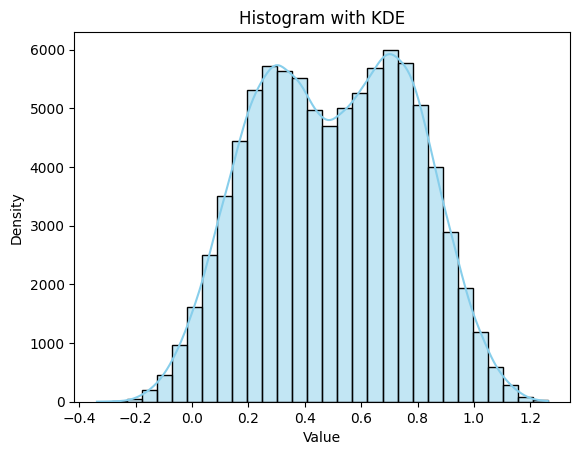

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

res = model.predict(
    df_features[SIDE_ALL][df_label_side["bin"].astype(int) != 0]
)

sns.histplot(res, kde=True, bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram with KDE")
plt.show()

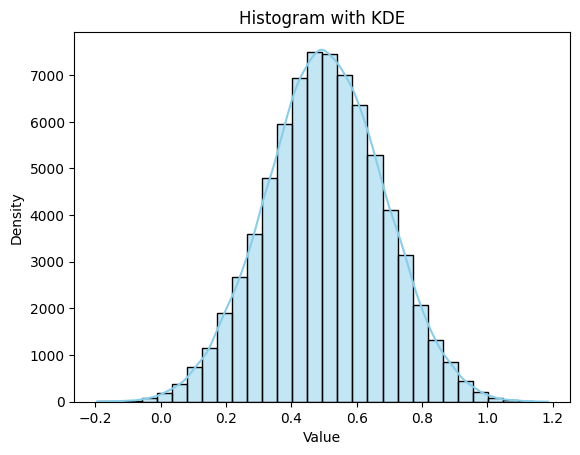

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

res = model.predict(
    df_features[SIDE_ALL][df_label_side["bin"].astype(int) == 0]
)

sns.histplot(res, kde=True, bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram with KDE")
plt.show()

In [12]:
model.save_model("custom_indicators/models/model_side.txt")

# meta model

In [7]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from custom_indicators.selection import SIDE_ALL

df_features = pd.read_parquet("data/features_15m.parquet")
df_label = pd.read_parquet("data/label_15m_meta.parquet")

model_side = lgb.Booster(model_file="custom_indicators/models/model_side.txt")
model_side_res = model_side.predict(df_features[SIDE_ALL])
df_features["model_side_res"] = model_side_res

df_features = df_features.iloc[240:]
df_label = df_label.iloc[240:]

print(df_features.shape)

assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(163440, 1264)
(163440, 9)


,open,high,low,close,volume,ret,trgt,bin,side
2020-06-03 12:00:00+00:00,9614.16,9644.00,9604.00,9604.54,4439.730,0.007946,0.002427,1.0,-1.0
2020-06-03 12:15:00+00:00,9604.53,9614.88,9586.00,9586.01,2039.129,0.006002,0.002454,1.0,-1.0
2020-06-03 12:30:00+00:00,9586.55,9605.94,9544.01,9577.90,3871.894,0.004005,0.002543,0.0,-1.0
2020-06-03 12:45:00+00:00,9577.85,9608.23,9569.28,9594.00,1795.565,0.006840,0.002599,1.0,-1.0
2020-06-03 13:00:00+00:00,9594.00,9609.59,9585.33,9590.51,1521.625,0.000000,0.002614,0.0,0.0


In [8]:
from custom_indicators.selection import META_ALL

# valid_mask = df_label["ret"].notna().tolist()
valid_mask = [True] * df_features.shape[0]

meta_features = df_features[valid_mask][META_ALL]
print(meta_features.shape)
meta_label = df_label[valid_mask]["bin"].astype(int)

train_test_split_point = int(meta_features.shape[0] * 0.8)
meta_features_train = meta_features.iloc[:train_test_split_point]
meta_features_test = meta_features.iloc[train_test_split_point:]
meta_label_train = meta_label.iloc[:train_test_split_point]
meta_label_test = meta_label.iloc[train_test_split_point:]

meta_label_test.value_counts()

(163440, 1058)


bin
0    25147
1     7541
Name: count, dtype: int64

In [9]:
import lightgbm as lgb
import optuna
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score


def objective(trial):
    params = {
        "objective": "binary",
        "is_unbalance": True,
        "metric": "auc",
        "num_threads": -1,
        "verbose": -1,
        "early_stopping_round": 100,
        "boosting": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 31, 300),
        "max_depth": trial.suggest_int("max_depth", 30, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 1),
    }
    dtrain = lgb.Dataset(meta_features_train, meta_label_train)
    dtest = lgb.Dataset(meta_features_test, meta_label_test)
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtest],
        num_boost_round=trial.suggest_int("num_boost_round", 300, 1000),
    )
    pred_proba = model.predict(meta_features_test)
    pred_label = (pred_proba > 0.5).astype(int)
    precision = precision_score(meta_label_test, pred_label)
    recall = recall_score(meta_label_test, pred_label)
    f1 = f1_score(meta_label_test, pred_label)
    auc = roc_auc_score(meta_label_test, pred_proba)
    print(f"precision: {precision}, recall: {recall}, f1: {f1}, auc: {auc}")
    return f1


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=50, n_jobs=1)

/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_50505/2334694026.py:42: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=2),
[I 2025-02-22 21:43:19,834] A new study created in memory with name: no-name-c534e853-66e7-476c-a8fa-d4b02340879b
[I 2025-02-22 21:43:42,191] Trial 0 finished with value: 0.5540866027939838 and parameters: {'num_leaves': 94, 'max_depth': 75, 'min_gain_to_split': 0.32357442300093575, 'min_data_in_leaf': 189, 'lambda_l1': 0.986058568262665, 'lambda_l2': 0.2013747841629827, 'num_boost_round': 749}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.4645485550170526, recall: 0.6863811165627901, f1: 0.5540866027939838, auc: 0.8280325978433127


[I 2025-02-22 21:43:58,945] Trial 1 finished with value: 0.5528712037475657 and parameters: {'num_leaves': 42, 'max_depth': 64, 'min_gain_to_split': 0.9880614438198596, 'min_data_in_leaf': 176, 'lambda_l1': 0.2719092181419298, 'lambda_l2': 0.6061408137073767, 'num_boost_round': 675}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.458369698027579, recall: 0.6964593555231402, f1: 0.5528712037475657, auc: 0.8284777142809774


[I 2025-02-22 21:44:51,747] Trial 2 finished with value: 0.5449295449295449 and parameters: {'num_leaves': 266, 'max_depth': 31, 'min_gain_to_split': 0.05378965400694336, 'min_data_in_leaf': 38, 'lambda_l1': 0.6476389637356077, 'lambda_l2': 0.8514997807034818, 'num_boost_round': 564}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.4826598465473146, recall: 0.6256464659859435, f1: 0.5449295449295449, auc: 0.827236130033061


[I 2025-02-22 21:45:31,057] Trial 3 finished with value: 0.5473909613434014 and parameters: {'num_leaves': 181, 'max_depth': 49, 'min_gain_to_split': 0.8998257781885913, 'min_data_in_leaf': 68, 'lambda_l1': 0.6888769760838359, 'lambda_l2': 0.21483652344261178, 'num_boost_round': 578}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.4759431651151396, recall: 0.6440790346107943, f1: 0.5473909613434014, auc: 0.828008989148844


[I 2025-02-22 21:46:09,232] Trial 4 finished with value: 0.5435944071842673 and parameters: {'num_leaves': 248, 'max_depth': 69, 'min_gain_to_split': 0.34135574701925303, 'min_data_in_leaf': 77, 'lambda_l1': 0.46280178814636336, 'lambda_l2': 0.1485847035902712, 'num_boost_round': 845}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.4756789018203521, recall: 0.6341334040578173, f1: 0.5435944071842673, auc: 0.8261062929025204


[I 2025-02-22 21:46:55,593] Trial 5 finished with value: 0.5438954675377705 and parameters: {'num_leaves': 210, 'max_depth': 61, 'min_gain_to_split': 0.6736664092802206, 'min_data_in_leaf': 130, 'lambda_l1': 0.9220904936634636, 'lambda_l2': 0.19712823171640542, 'num_boost_round': 492}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.4855238491980837, recall: 0.6182203951730539, f1: 0.5438954675377705, auc: 0.826525817873967


[I 2025-02-22 21:47:34,661] Trial 6 finished with value: 0.5428521353040836 and parameters: {'num_leaves': 210, 'max_depth': 72, 'min_gain_to_split': 0.5091934912929879, 'min_data_in_leaf': 150, 'lambda_l1': 0.0017692498467649182, 'lambda_l2': 0.5218101341658228, 'num_boost_round': 652}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.485171261487051, recall: 0.6160986606550856, f1: 0.5428521353040836, auc: 0.8270394401302255


[I 2025-02-22 21:48:09,327] Trial 7 finished with value: 0.5483445228668159 and parameters: {'num_leaves': 204, 'max_depth': 54, 'min_gain_to_split': 0.5273646621843741, 'min_data_in_leaf': 90, 'lambda_l1': 0.012588641574220728, 'lambda_l2': 0.922002725553575, 'num_boost_round': 399}. Best is trial 0 with value: 0.5540866027939838.


precision: 0.483309730932632, recall: 0.6336029704283251, f1: 0.5483445228668159, auc: 0.8285671446695183


[W 2025-02-22 21:48:17,627] Trial 8 failed with parameters: {'num_leaves': 247, 'max_depth': 94, 'min_gain_to_split': 0.9752106404146624, 'min_data_in_leaf': 52, 'lambda_l1': 0.423273947210587, 'lambda_l2': 0.6562152511924918, 'num_boost_round': 373} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_50505/2334694026.py", line 24, in objective
    model = lgb.train(
            ^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/lightgbm/engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/lightgbm/basic.py", line 4155, in update
    _LIB.LGBM_B

KeyboardInterrupt: 

In [10]:
study.best_params

{'num_leaves': 94,
 'max_depth': 75,
 'min_gain_to_split': 0.32357442300093575,
 'min_data_in_leaf': 189,
 'lambda_l1': 0.986058568262665,
 'lambda_l2': 0.2013747841629827,
 'num_boost_round': 749}

In [11]:
params = {
    "is_unbalance": True,
    **study.best_params,
}

model = lgb.train(
    study.best_params,
    lgb.Dataset(meta_features_train, meta_label_train),
)

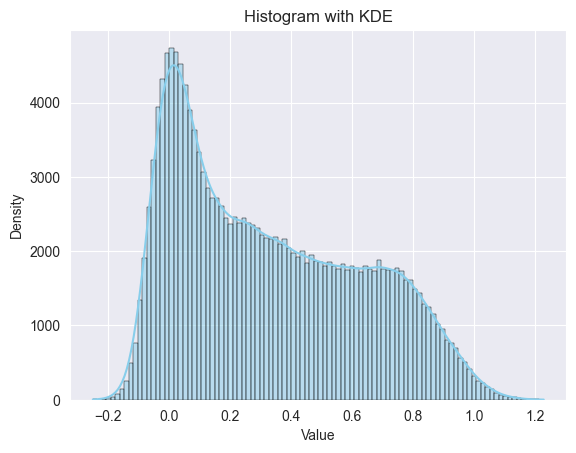

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

res = model.predict(
    df_features[META_ALL]
)

sns.histplot(res, kde=True, bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Histogram with KDE")
plt.show()

In [13]:
model.save_model("custom_indicators/models/model_meta.txt")